### Intro

This note book will organize the galaxy catalogs from the UniverseMachine model using the small multidark planck simulation (SMDPL).  The results are provided by Peter Behroozi, and the initial catalogs are made by Christopher Bradshaw. 

The models are for galaxies at z~0.4.  Two models are provided: 
1. `sfr_catalog_0.712400.txt.gz`: old fashion `bcg` and `icl` components one. 
2. `sfr_catalog_insitu_exsitu_0.712400.txt.gz`: new `in-situ` and `ex-situ` components one. 
3. `particles_0.712400.txt.gz`: DM particles file. 

The useful information has been summarized into a smaller catalog, also the central and satellite galaxies are separated now.  (`.npz`) format. 

Here, we: 

1. Explore the basic properties of these new models. 
2. Compare their SMF with observed ones. 
3. Explore new M100-M10 models.
4. Select the relevant massive galaxies, and save the value-added catalog. 

We also need to downsample the particle tables and pre-compute the `DeltaSigma` signals around the selected massive galaxies.

#### Small MultiDark Simulation

* For details, please see: https://www.cosmosim.org/cms/simulations/smdpl/

![](data/cosmosim_smdpl_sum.png)

In [2]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

import numpy as np 
import matplotlib.pyplot as plt
    
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

from astropy.table import Table, Column, vstack

%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)

# Personal repo
from asap.um_prepare_catalog import prep_um_catalog
from asap.um_vagc_mock import *
    
from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    smhm, \
    plotting

## Old model (before 1806): Summary catalogs for SMDPL-UniverseMachine model

In [2]:
# Setup environment 
#envir = s16a_path.set_env(version='astro5')
envir = s16a_path.set_env(version='kungpao')

# Folder for new UM model 
um_dir = os.path.join(envir['s16a'], 'um2/um2_new')
um_smdpl_dir = os.path.join(um_dir, 'um_smdpl_small')

# Summary catalogs for new UM models 
um_smdpl_old = np.load(os.path.join(um_smdpl_dir, 
                                    'sfr_catalog_0.712400_final.npz'))
um_smdpl_new = np.load(os.path.join(um_smdpl_dir, 
                                    'sfr_catalog_insitu_exsitu_0.712400_final_extended.npz'))

# Results for central and satellite galaxies
um_smdpl_old_cen = Table(um_smdpl_old['centrals'])
um_smdpl_old_sat = Table(um_smdpl_old['satellites'])

um_smdpl_new_cen = Table(um_smdpl_new['centrals'])
um_smdpl_new_sat = Table(um_smdpl_new['satellites'])

print(len(um_smdpl_old_cen), len(um_smdpl_old_sat))
print(len(um_smdpl_new_cen), len(um_smdpl_new_sat))

print(um_smdpl_old_cen.colnames)

385125 10809469
385125 10809469
['id', 'upid', 'x', 'y', 'z', 'm', 'mp', 'sm', 'icl', 'sfr']


In [3]:
# vstack the centrals and satellites 
um_smdpl_old_all = vstack([um_smdpl_old_cen, um_smdpl_old_sat])
um_smdpl_new_all = vstack([um_smdpl_new_cen, um_smdpl_new_sat])

um_smdpl_new_all.rename_column('mvir', 'mvir_hlist')
um_smdpl_new_all.rename_column('rvir', 'rvir_hlist')
um_smdpl_new_all.rename_column('rs', 'rs_hlist')
um_smdpl_new_all.rename_column('Halfmass_Scale', 'scale_half_mass')
um_smdpl_new_all.rename_column('scale_of_last_MM', 'scale_last_mm')
um_smdpl_new_all.rename_column('M200b', 'm200b_hlist')
um_smdpl_new_all.rename_column('M200c', 'm200c_hlist')
um_smdpl_new_all.rename_column('Acc_Rate_Inst', 'acc_rate_inst')
um_smdpl_new_all.rename_column('Acc_Rate_100Myr', 'acc_rate_100myr')
um_smdpl_new_all.rename_column('Acc_Rate_1*Tdyn', 'acc_rate_1_tdyn')
um_smdpl_new_all.rename_column('Acc_Rate_2*Tdyn', 'acc_rate_2_tdyn')
um_smdpl_new_all.rename_column('Acc_Rate_Mpeak', 'acc_rate_mpeak')
um_smdpl_new_all.rename_column('Vmax@Mpeak', 'vmax_at_mpeak')

# Value added the catalogs 
um_smdpl_old_all = value_added_smdpl_mock(um_smdpl_old_all)
um_smdpl_new_all = value_added_smdpl_mock(um_smdpl_new_all)

In [14]:
um_smdpl_old_all_vagc = prep_um_catalog(um_smdpl_old_all, um_min_mvir=11.5)
um_smdpl_new_all_vagc = prep_um_catalog(um_smdpl_new_all, um_min_mvir=11.5)

print(um_smdpl_new_all_vagc.colnames)
print(len(um_smdpl_new_all_vagc))

['halo_id', 'upid', 'x', 'y', 'z', 'mvir', 'mpeak', 'sm', 'icl', 'sfr', 'mvir_hlist', 'rvir_hlist', 'rs_hlist', 'scale_half_mass', 'scale_last_mm', 'm200b_hlist', 'm200c_hlist', 'acc_rate_inst', 'acc_rate_100myr', 'acc_rate_1_tdyn', 'acc_rate_2_tdyn', 'acc_rate_mpeak', 'vmax_at_mpeak', 'halo_hostid', 'mhalo_host', 'mask_central', 'mtot_galaxy', 'mstar_mhalo', 'logms_gal', 'logms_icl', 'logms_tot', 'logms_halo', 'logmh_vir', 'logmh_peak', 'logmh_host']
11193763


In [10]:
# Save the results

# FITS table
um_smdpl_old_all_vagc.write(os.path.join(um_dir,
                                         'um_smdpl_0.7124_old_vagc_mhost_11.5.fits'),
                            format='fits', overwrite=True)
um_smdpl_new_all_vagc.write(os.path.join(um_dir,
                                         'um_smdpl_0.7124_new_vagc_mhost_11.5_extended.fits'),
                            format='fits', overwrite=True)

# Numpy array 
np.save(os.path.join(um_dir,
                     'um_smdpl_0.7124_old_vagc_mhost_11.5.npy'),
        np.asarray(um_smdpl_old_all_vagc)
       )
np.save(os.path.join(um_dir,
                     'um_smdpl_0.7124_new_vagc_mhost_11.5_extended.npy'),
        np.asarray(um_smdpl_new_all_vagc)
       )

## New In-situ vs. Ex-situ model [1809]

In [17]:
smdpl_dir = "/Users/song/data/massive/umachine/1806/smdpl_nomergers/"

# New galaxy v.s. IHL model using SMDPL
um_smdpl = np.load(
    os.path.join(smdpl_dir, "sfr_catalog_insitu_exsitu_0.712400_final_logmp_11_extended.npz"))

# Results for central and satellite galaxies
um_smdpl_cen = Table(um_smdpl['centrals'])
um_smdpl_sat = Table(um_smdpl['satellites'])

print(len(um_smdpl_cen) + len(um_smdpl_sat))

print(um_smdpl_cen.colnames)

17683329
['id', 'upid', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'm', 'mp', 'vmp', 'r', 'sm', 'icl', 'sfr', 'ssfr', 'pid', 'mvir_hlist', 'rvir_hlist', 'rs_hlist', 'scale_half_mass', 'scale_last_mm', 'm200b_hlist', 'm200c_hlist', 'gamma_inst', 'gamma_100myr', 'gamma_1tdyn', 'gamma_2tdyn', 'gamma_mpeak', 'vmax_mpeak']


In [18]:
# vstack the centrals and satellites 
um_smdpl_all = vstack([um_smdpl_cen, um_smdpl_sat])

# Rename columns, apply periodic boundary conditions, 
um_smdpl_all_vagc = value_added_smdpl_mock(um_smdpl_all)

# Final preparation of the catalog
# Make a halo mass cut
# Log M_Peak >= 11.5
um_smdpl_all_mpcut = prep_um_catalog(um_smdpl_all_vagc, mhalo_col='logmh_peak', um_min_mvir=11.5)

# Log M_Vir >= 11.5
um_smdpl_all_mvcut = prep_um_catalog(um_smdpl_all_vagc, mhalo_col='logmh_vir', um_min_mvir=11.5)

print(um_smdpl_all_mpcut.colnames)

print("\n", len(um_smdpl_all_mpcut), len(um_smdpl_all_mvcut))

['halo_id', 'upid', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'mvir', 'mpeak', 'vmp', 'r', 'sm', 'icl', 'sfr', 'ssfr', 'pid', 'mvir_hlist', 'rvir_hlist', 'rs_hlist', 'scale_half_mass', 'scale_last_mm', 'm200b_hlist', 'm200c_hlist', 'gamma_inst', 'gamma_100myr', 'gamma_1tdyn', 'gamma_2tdyn', 'gamma_mpeak', 'vmax_mpeak', 'halo_hostid', 'mhalo_host', 'mask_central', 'mtot_galaxy', 'mstar_mhalo', 'logms_gal', 'logms_icl', 'logms_tot', 'logms_halo', 'logmh_vir', 'logmh_peak', 'logmh_host']

 1557939 1255175


In [19]:
# FITS table
um_smdpl_all_mpcut.write(os.path.join(smdpl_dir, 'um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5.fits'),
                         format='fits', overwrite=True)

um_smdpl_all_mvcut.write(os.path.join(smdpl_dir, 'um_smdpl_insitu_exsitu_0.7124_basic_logmv_11.5.fits'),
                         format='fits', overwrite=True)

# Numpy array 
np.save(os.path.join(smdpl_dir, 'um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5.npy'),
        np.asarray(um_smdpl_all_mpcut))

np.save(os.path.join(smdpl_dir, 'um_smdpl_insitu_exsitu_0.7124_basic_logmv_11.5.npy'),
        np.asarray(um_smdpl_all_mvcut))

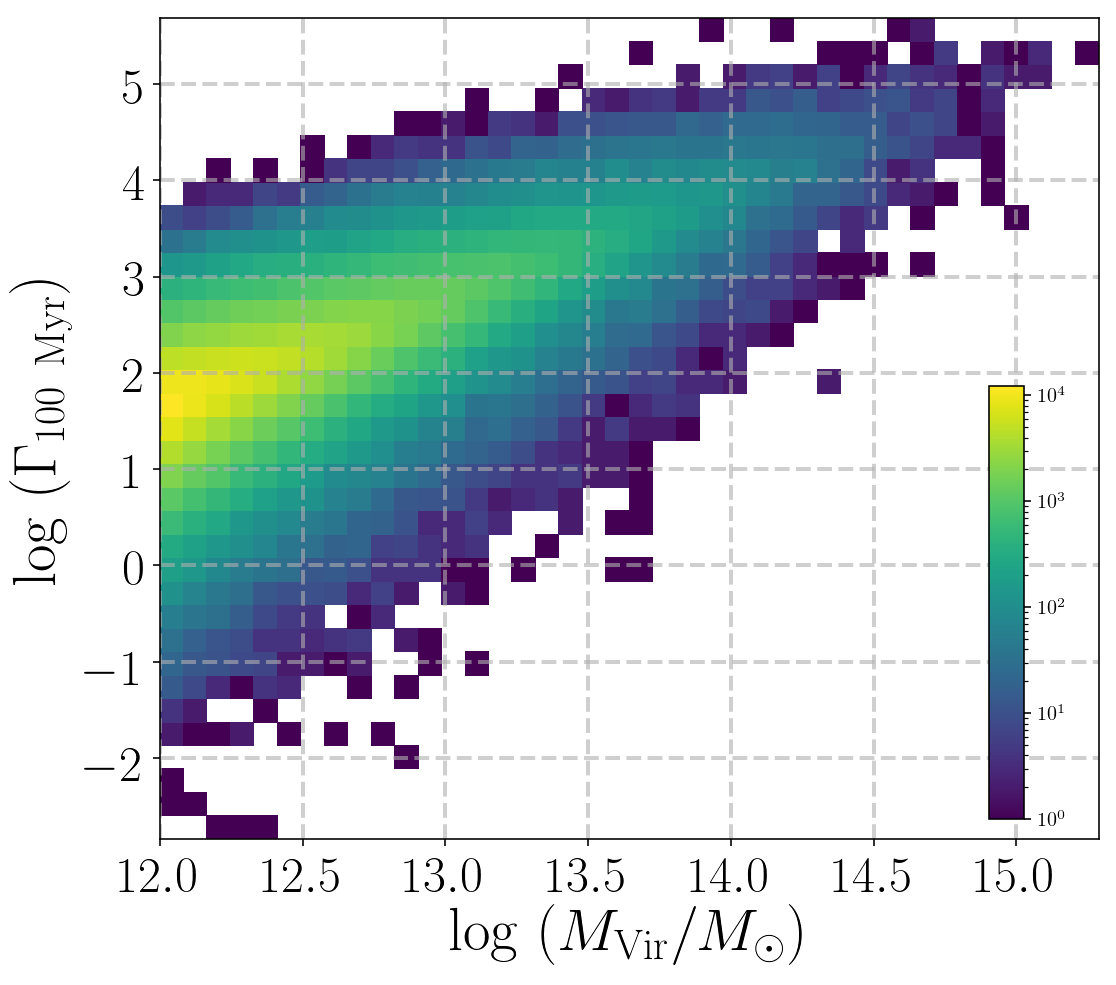

In [66]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(left=0.18, right=0.995, 
                    bottom=0.18, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

mask_cen = ((um_smdpl_all_mpcut['upid'] == -1) & (um_smdpl_all_mpcut['logmh_vir'] >= 12.0) & 
            (um_smdpl_all_mpcut['gamma_100myr'] > 0))

_, _, _, cax1 = ax1.hist2d(
    um_smdpl_all_mpcut[mask_cen]['logmh_vir'], 
    np.log10(um_smdpl_all_mpcut[mask_cen]['gamma_100myr']), 
    bins=[40, 35], norm=LogNorm())

ax1.grid(linestyle='--', alpha=0.6, linewidth=2.0)

cbaxes1 = fig.add_axes([0.90, 0.20, 0.03, 0.43]) 
cbar1 = fig.colorbar(cax1, cax=cbaxes1)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

_ = ax1.set_xlabel(r'$\log\ (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\log\ (\Gamma_{100\ \mathrm{Myr}})$', fontsize=30)

Text(0, 0.5, '$\\log\\ (\\mathrm{SFR}/[M_{\\odot}\\ \\mathrm{yr}^{-1}])$')

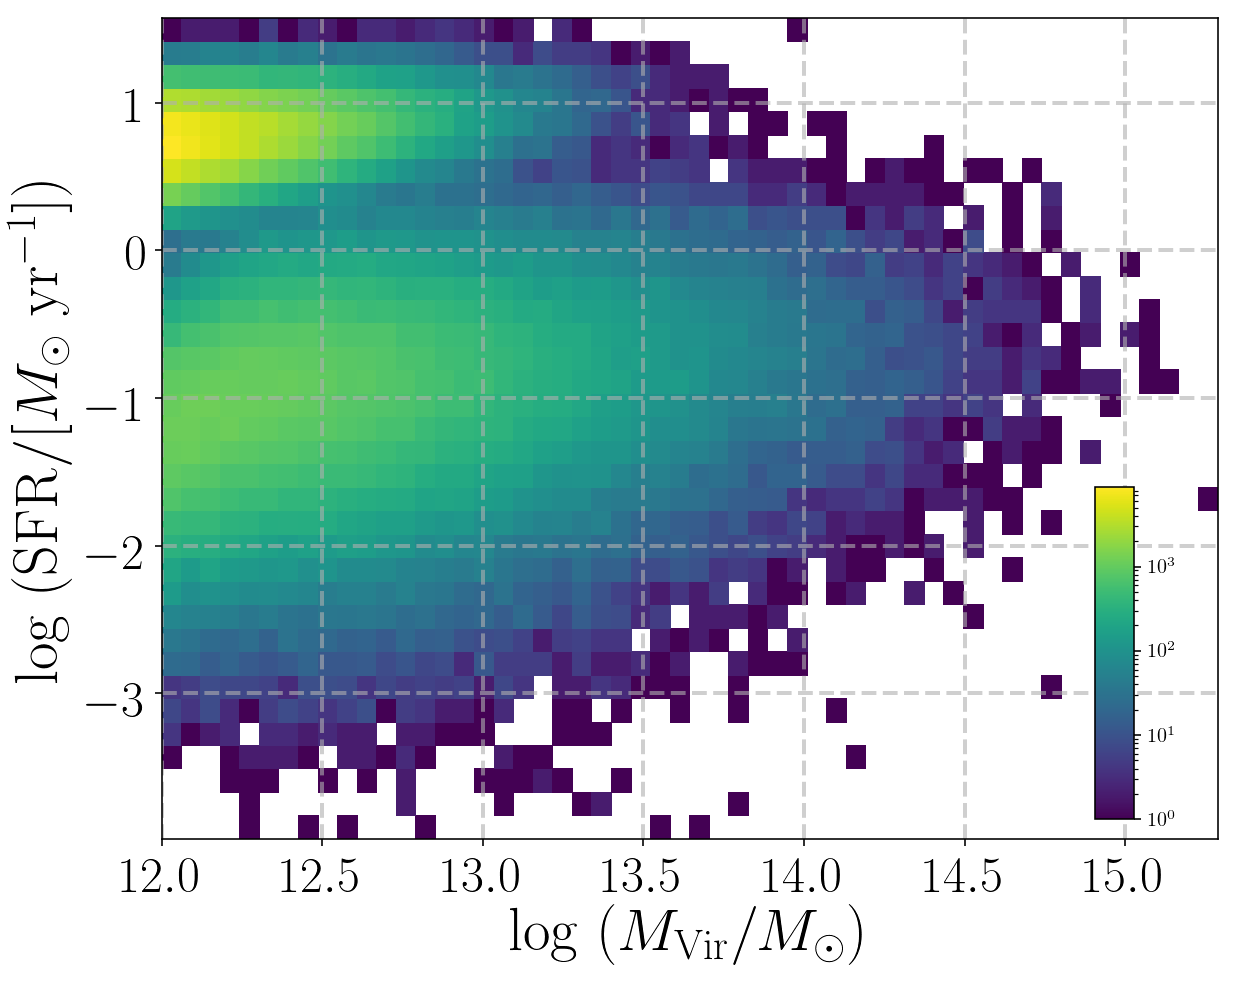

In [67]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.18, right=0.995, 
                    bottom=0.18, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

mask_cen = ((um_smdpl_all_mpcut['upid'] == -1) & (um_smdpl_all_mpcut['logmh_vir'] >= 12.0) & 
            (um_smdpl_all_mpcut['gamma_100myr'] > 0) & (um_smdpl_all_mpcut['sfr'] > 1E-4))

_, _, _, cax1 = ax1.hist2d(
    um_smdpl_all_mpcut[mask_cen]['logmh_vir'], 
    np.log10(um_smdpl_all_mpcut[mask_cen]['sfr']), 
    bins=[54, 35], norm=LogNorm())

ax1.grid(linestyle='--', alpha=0.6, linewidth=2.0)

cbaxes1 = fig.add_axes([0.90, 0.20, 0.03, 0.33]) 
cbar1 = fig.colorbar(cax1, cax=cbaxes1)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_xlabel(r'$\log\ (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
ax1.set_ylabel(r'$\log\ (\mathrm{SFR}/[M_{\odot}\ \mathrm{yr}^{-1}])$', fontsize=30)

/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


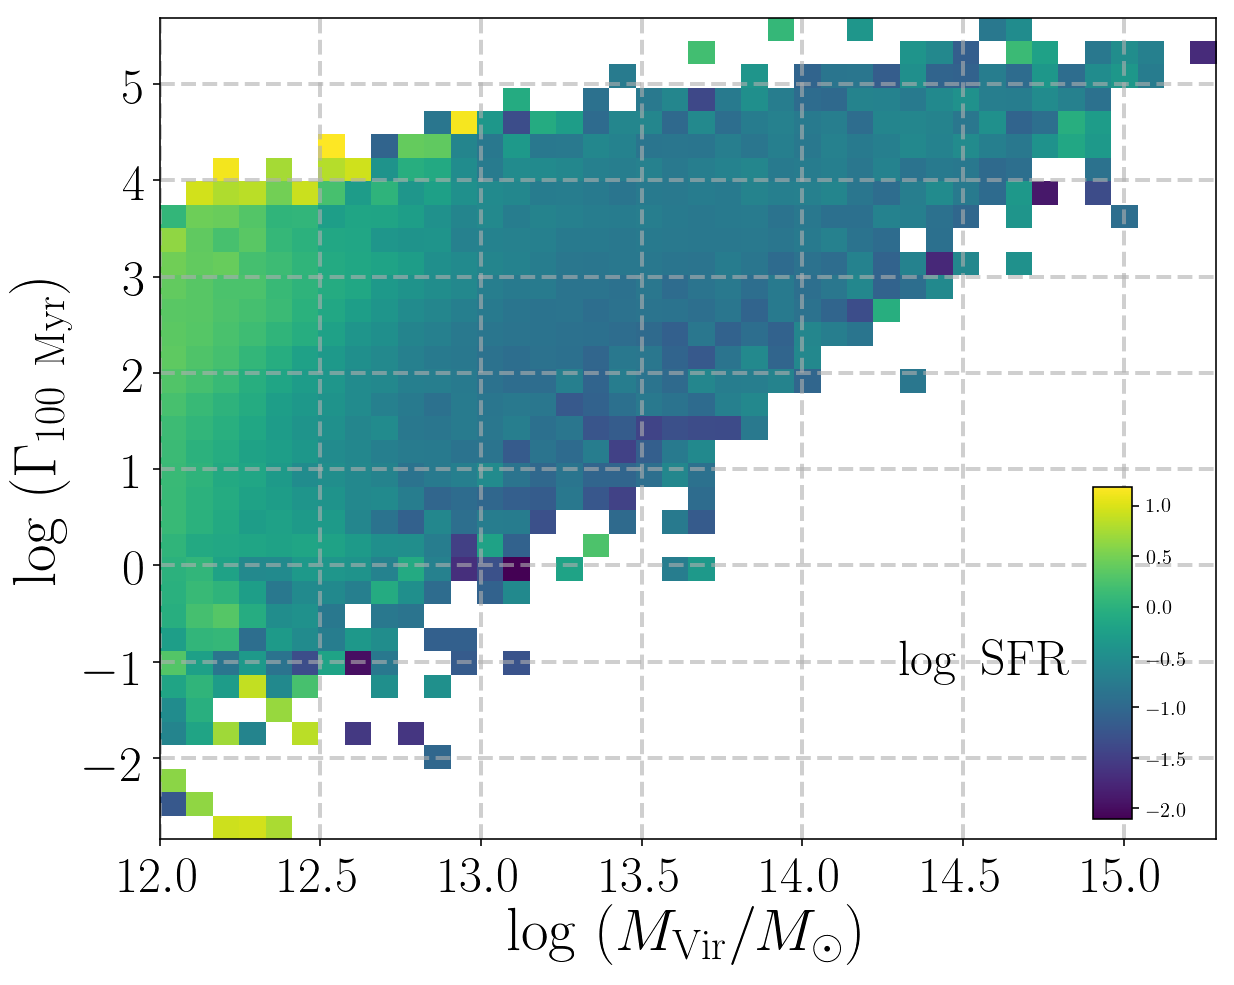

In [71]:
from astroML.stats import binned_statistic_2d

fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.18, right=0.995, 
                    bottom=0.18, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

mask_cen = ((um_smdpl_all_mpcut['upid'] == -1) & (um_smdpl_all_mpcut['logmh_vir'] >= 12.0) & 
            (um_smdpl_all_mpcut['gamma_100myr'] > 0) & (um_smdpl_all_mpcut['sfr'] > 1E-4))

sfr_mean, xedges, yedges = binned_statistic_2d(
    um_smdpl_all_mpcut[mask_cen]['logmh_vir'], 
    np.log10(um_smdpl_all_mpcut[mask_cen]['gamma_100myr']),
    np.log10(um_smdpl_all_mpcut[mask_cen]['sfr']), 
    'mean', bins=[40, 35])

cax1 = ax1.imshow(sfr_mean.T, origin='lower',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                  aspect='auto', interpolation='nearest')

ax1.grid(linestyle='--', alpha=0.6, linewidth=2.0)

cbaxes1 = fig.add_axes([0.90, 0.20, 0.03, 0.33]) 
cbar1 = fig.colorbar(cax1, cax=cbaxes1)

ax1.text(0.7, 0.2, r'$\log\ \mathrm{SFR}$', fontsize=25, transform=ax1.transAxes)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
_ = ax1.set_xlabel(r'$\log\ (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\log\ (\Gamma_{100\ \mathrm{Myr}})$', fontsize=30)

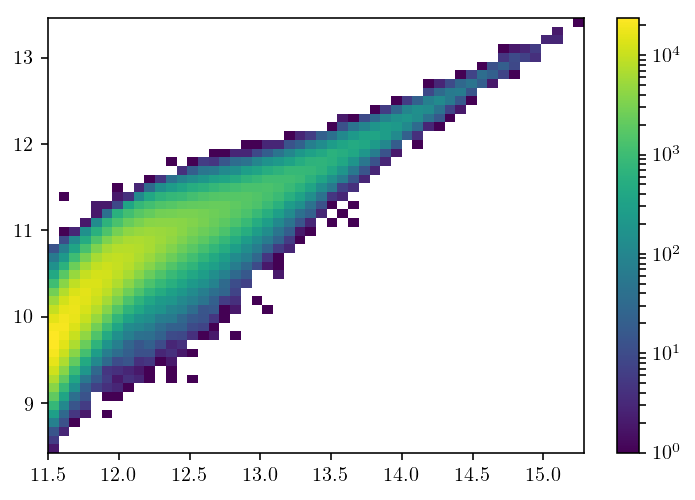

In [32]:
mask_cen = (um_smdpl_all_mpcut['upid'] == -1)

plt.hist2d(um_smdpl_all_mpcut[mask_cen]['logmh_peak'], 
           um_smdpl_all_mpcut[mask_cen]['logms_halo'], 
           bins=[50, 50], norm=LogNorm())

plt.colorbar()
plt.show()

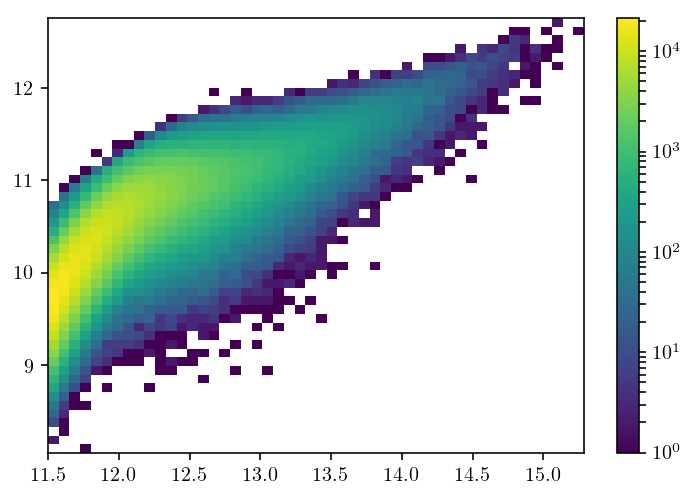

In [36]:
plt.hist2d(um_smdpl_all_mpcut[mask_cen]['logmh_peak'], 
           um_smdpl_all_mpcut[mask_cen]['logms_tot'], 
           bins=[50, 50], norm=LogNorm())

plt.colorbar()
plt.show()

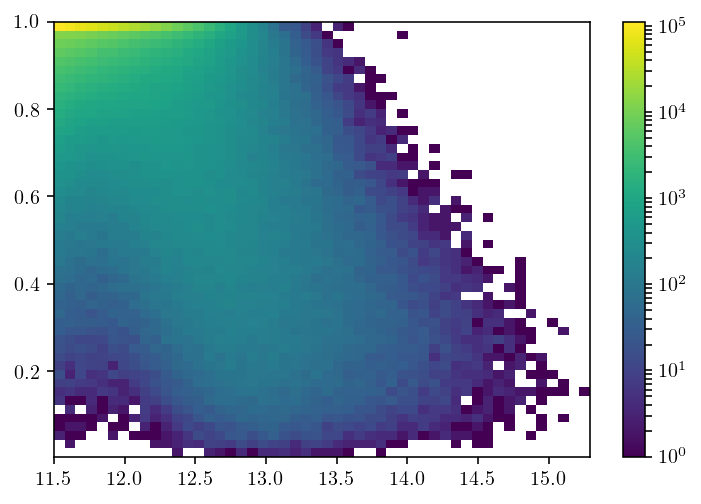

In [33]:
frac_cen = (10.0 ** um_smdpl_all_mpcut[mask_cen]['logms_tot']) / (10.0 ** um_smdpl_all_mpcut[mask_cen]['logms_halo'])

plt.hist2d(um_smdpl_all_mpcut[mask_cen]['logmh_peak'], frac_cen,
           bins=[50, 50], norm=LogNorm())

plt.colorbar()
plt.show()

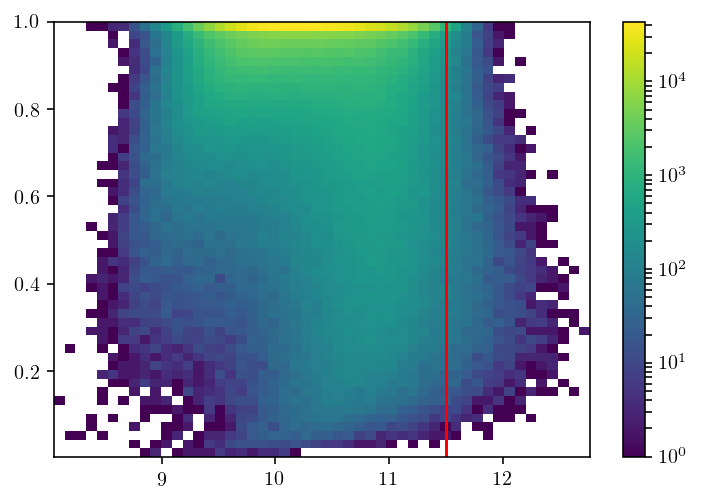

In [35]:
frac_cen = (10.0 ** um_smdpl_all_mpcut[mask_cen]['logms_tot']) / (10.0 ** um_smdpl_all_mpcut[mask_cen]['logms_halo'])

plt.hist2d(um_smdpl_all_mpcut[mask_cen]['logms_tot'], frac_cen,
           bins=[50, 50], norm=LogNorm())

plt.axvline(11.5, c='r')
plt.colorbar()
plt.show()